Task 3: Customer Segmentation / Clustering

import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA


import data from csv files

In [26]:

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')
customers_df.head()


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,10-07-2022
1,C0002,Elizabeth Lutz,Asia,13-02-2022
2,C0003,Michael Rivera,South America,07-03-2024
3,C0004,Kathleen Rodriguez,South America,09-10-2022
4,C0005,Laura Weber,Asia,15-08-2022


In [27]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,25-08-2024 12:38,1,300.68,300.68
1,T00112,C0146,P067,27-05-2024 22:23,1,300.68,300.68
2,T00166,C0127,P067,25-04-2024 07:38,1,300.68,300.68
3,T00272,C0087,P067,26-03-2024 22:55,2,601.36,300.68
4,T00363,C0070,P067,21-03-2024 15:10,3,902.04,300.68


In [28]:
products_df.head()


,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


Data Preprocessing

In [29]:
# Aggregate transaction data for each customer
transaction_features = transactions_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),                                  # Total value spent by the customer
    transaction_count=('TransactionID', 'count'),                       # Total number of transactions
    avg_transaction_value=('TotalValue', 'mean')                        # Average value per transaction
).reset_index()

# Merge the aggregated transaction data with the customer profile data
merged_df = pd.merge(customers_df, transaction_features, on='CustomerID', how='left')

# Fill missing values (if any) with 0
merged_df.fillna(0, inplace=True)


merged_df.head()


,CustomerID,CustomerName,Region,SignupDate,total_spend,transaction_count,avg_transaction_value
0,C0001,Lawrence Carroll,South America,10-07-2022,3354.52,5.0,670.904
1,C0002,Elizabeth Lutz,Asia,13-02-2022,1862.74,4.0,465.685
2,C0003,Michael Rivera,South America,07-03-2024,2725.38,4.0,681.345
3,C0004,Kathleen Rodriguez,South America,09-10-2022,5354.88,8.0,669.360
4,C0005,Laura Weber,Asia,15-08-2022,2034.24,3.0,678.080


Feature Scaling

In [30]:

from sklearn.preprocessing import StandardScaler

# Select the relevant numerical features for clustering

features = merged_df[['total_spend', 'transaction_count', 'avg_transaction_value']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features[:5]




array([[-0.05188436,  0.        , -0.05478053],
       [-0.86271433, -0.45129368, -0.9039848 ],
       [-0.393842  , -0.45129368, -0.01157526],
       [ 1.03537505,  1.35388105, -0.06116966],
       [-0.76949861, -0.90258736, -0.02508596]])

Apply Clustring( KMeans)

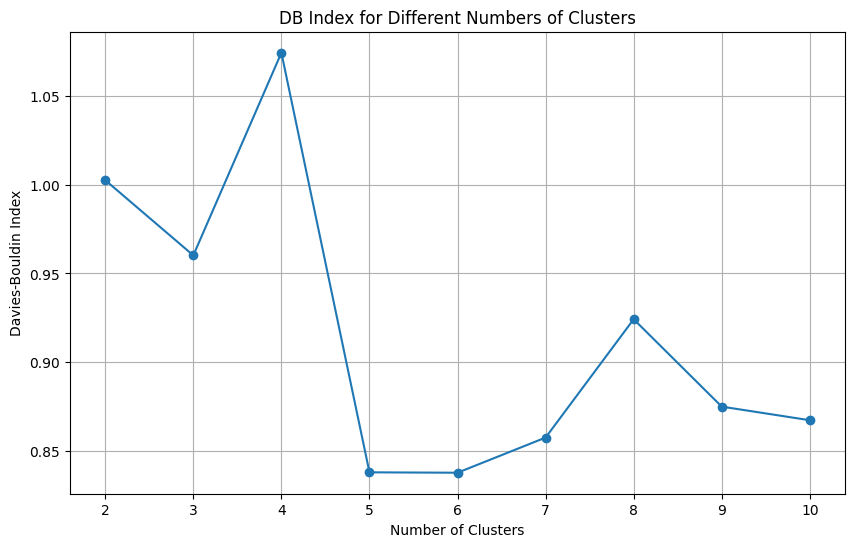

In [32]:

# Function to compute the Davies-Bouldin Index for different numbers of clusters

def compute_db_index(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    db_index = davies_bouldin_score(data, labels)
    return db_index, labels

# Try different numbers of clusters (from 2 to 10)

db_indexes = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    db_index, labels = compute_db_index(scaled_features, n_clusters)
    db_indexes.append(db_index)

# Plot the DB Index for different numbers of clusters

plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, db_indexes, marker='o')
plt.title('DB Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

# From the DB Index plot, choose the optimal number of clusters (e.g., 3)

optimal_n_clusters = 3


Apply KMeans with the Optimal Number of Clusters

In [33]:
# Apply KMeans with the optimal number of clusters (e.g., 3)

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
final_labels = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the merged data

merged_df['Cluster'] = final_labels


merged_df.head()


,CustomerID,CustomerName,Region,SignupDate,total_spend,transaction_count,avg_transaction_value,Cluster
0,C0001,Lawrence Carroll,South America,10-07-2022,3354.52,5.0,670.904,1
1,C0002,Elizabeth Lutz,Asia,13-02-2022,1862.74,4.0,465.685,1
2,C0003,Michael Rivera,South America,07-03-2024,2725.38,4.0,681.345,1
3,C0004,Kathleen Rodriguez,South America,09-10-2022,5354.88,8.0,669.360,0
4,C0005,Laura Weber,Asia,15-08-2022,2034.24,3.0,678.080,1


Visualization of Clusters

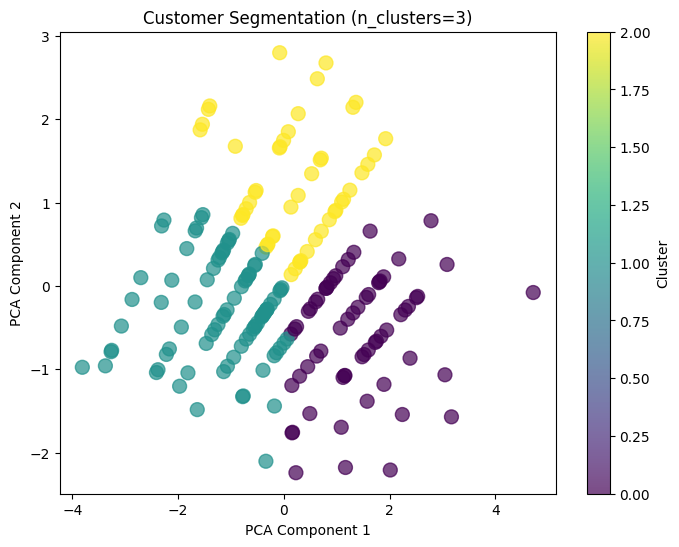

In [37]:

# Reduce dimensionality to 2 components using PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plot the clusters in a 2D space

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=final_labels, cmap='viridis', s=100, alpha=0.7)
plt.title(f'Customer Segmentation (n_clusters={optimal_n_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


Clustering Metrics

In [38]:
from sklearn.metrics import silhouette_score

# Compute the Silhouette Score for the optimal clustering

silhouette_avg = silhouette_score(scaled_features, final_labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")


Silhouette Score: 0.357


FINAL SCRIPT

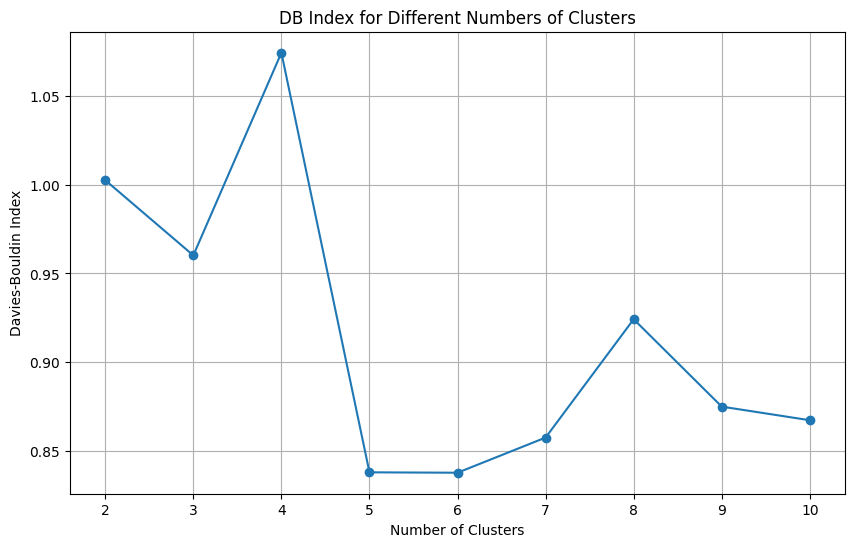

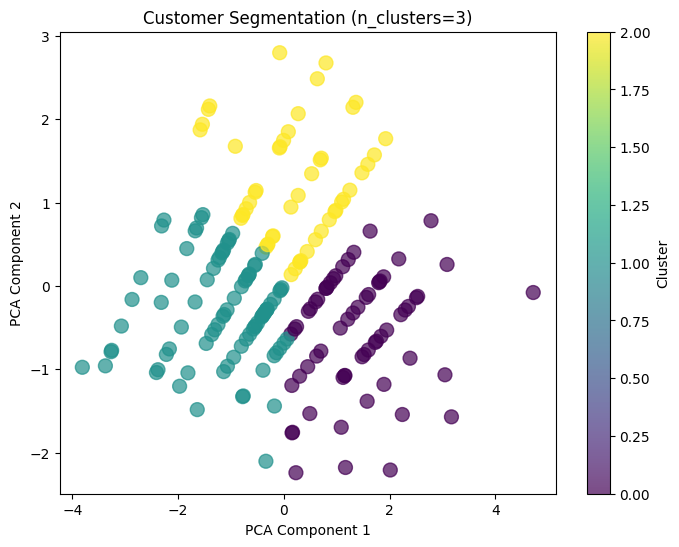

Silhouette Score: 0.357


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Step 1: Load the data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')

# Step 2: Aggregate transaction data for each customer
transaction_features = transactions_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

# Merge the transaction features with customer profile data
merged_df = pd.merge(customers_df, transaction_features, on='CustomerID', how='left')

# Fill missing values with 0 (customers with no transactions)
merged_df.fillna(0, inplace=True)

# Step 3: Feature Scaling
features = merged_df[['total_spend', 'transaction_count', 'avg_transaction_value']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 4: KMeans Clustering
def compute_db_index(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    db_index = davies_bouldin_score(data, labels)
    return db_index, labels

# Find optimal number of clusters using DBI
db_indexes = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    db_index, labels = compute_db_index(scaled_features, n_clusters)
    db_indexes.append(db_index)

# Plot DB Index for different clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, db_indexes, marker='o')
plt.title('DB Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (from the DBI plot, let's assume 3)
optimal_n_clusters = 3

# Step 5: Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
final_labels = kmeans.fit_predict(scaled_features)

# Step 6: Add the cluster labels to the merged dataframe
merged_df['Cluster'] = final_labels

# Step 7: PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plot the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=final_labels, cmap='viridis', s=100, alpha=0.7)
plt.title(f'Customer Segmentation (n_clusters={optimal_n_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 8: Clustering metrics
silhouette_avg = silhouette_score(scaled_features, final_labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")
